In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('dark_background')
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.4.1


In [9]:
main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')

In [10]:
main_data

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [11]:
extra_data

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0
...,...,...,...,...
10379,20028,99,20028.png,0
10380,20029,99,20029.png,0
10381,20030,99,20030.png,0
10382,20031,99,20031.png,0


## Predicting cellType

In [30]:
from sklearn.model_selection import train_test_split
X = main_data['ImageName']
Y = main_data['cellType']

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainY = trainY.ravel()

In [31]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(7916,)
(7916,)
(1980,)
(1980,)


In [32]:
trainX_img_list = trainX.tolist()

In [33]:
def create_img_dataset(directory, img_list):
    IMAGE_SIZE = 27
    train_data = []
    for img in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, img)
        img = cv2.resize(cv2.imread(path), (IMAGE_SIZE,IMAGE_SIZE))
        train_data.append(np.array(img))
    print("Successfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data) / 255.0 

In [34]:
# CHANGE THE PATH TO IMAGE FOLDER IN YOUR LOCAL DEVICE!
path = r"C:\Users\User\Desktop\RMIT\Cloud - GitHub\Minh\ML\Asm\ASM2\patch_images"

trainX_img = create_img_dataset(path, trainX_img_list)

Extracting Image Progress: 100%|██████████| 7916/7916 [00:01<00:00, 6440.58it/s]

Successfully import images!


In [35]:
trainX_img

array([[[[0.69411765, 0.35294118, 0.52941176],
         [0.70196078, 0.31764706, 0.49803922],
         [0.63921569, 0.22745098, 0.41568627],
         ...,
         [0.88235294, 0.69803922, 0.8627451 ],
         [0.77647059, 0.57254902, 0.74117647],
         [0.85098039, 0.63137255, 0.79607843]],

        [[0.69803922, 0.35686275, 0.51764706],
         [0.74117647, 0.41176471, 0.58039216],
         [0.70980392, 0.4       , 0.57647059],
         ...,
         [0.85882353, 0.6745098 , 0.83921569],
         [0.82745098, 0.61568627, 0.78039216],
         [0.78431373, 0.55686275, 0.7254902 ]],

        [[0.8745098 , 0.55686275, 0.7254902 ],
         [0.90588235, 0.59607843, 0.76862745],
         [0.85490196, 0.56078431, 0.74117647],
         ...,
         [0.85490196, 0.67058824, 0.83137255],
         [0.85098039, 0.64313725, 0.80392157],
         [0.80784314, 0.58823529, 0.74901961]],

        ...,

        [[0.9372549 , 0.87843137, 0.93333333],
         [0.9372549 , 0.87843137, 0.93333333]

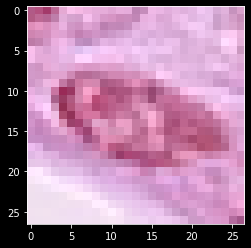

In [36]:
plt.imshow(trainX_img[0])

In [37]:
!pip install keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils